the objective of this notebook is to examine the likelihood functional form of the group multiplicity function. to do so, I will generate a series of mock galaxy catalogs using halotools, then look at the likelihood function using the mock catalogs. 

In [1]:
import os
import numpy as np
import pickle

import env
import util as UT

In [2]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.empirical_models.factories.mock_helpers import three_dim_pos_bundle
from halotools.mock_observables import FoFGroups
from astropy.table import Table

In [24]:
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.features import Features

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
def edge(index):
    zi = (index / 25) * 200.
    i2 = index % 25
    yi = (i2 / 5) * 200.
    i3 = i2 % 5
    xi = (i3) * 200.
    return xi , yi , zi

def mask_galaxy_table(pos , subvol_index):
    xi , yi , zi  = edge(subvol_index)
    submask = np.where((xi <pos[:, 0]) * \
                       (pos[:, 0] < xi + 200) * \
                       (yi <pos[:, 1]) * \
                       (pos[:, 1] < yi + 200) * \
                       (zi <pos[:, 2]) *  \
                       (pos[:, 2] < zi + 200))
    return pos[submask]

In [5]:
def richness(group_id):
    '''Calculate the richness of a group given group_ids of galaxies. Uses astropy.table module
    '''
    gals = Table()
    gals['groupid'] = group_id
    gals['dummy'] = 1
    grouped_table = gals.group_by('groupid')
    grp_richness = grouped_table['dummy'].groups.aggregate(np.sum)
    return np.array(grp_richness)

In [6]:
model = PrebuiltHodModelFactory('zheng07', threshold=-21)
halocat = CachedHaloCatalog(simname='multidark', redshift=0, halo_finder='rockstar')

In [7]:
b_perp = 0.14
b_para = 0.75
gmf_bins = np.array([5,7,10,14,20,28,40])

In [10]:
gmf_file = ''.join([UT.dat_dir(), 'submultidark.gmf.p'])
if os.path.isfile(gmf_file): 
    gmf_dict = pickle.load(open(gmf_file, 'rb'))
    gmfs = gmf_dict['gmfs']
else: 
    nbars, gmfs = [], []
    for i in range(1, 125): 
        print 'mock #', i
        model.populate_mock(halocat) # populate the halo catalog
        pos = three_dim_pos_bundle(model.mock.galaxy_table, 'x', 'y', 'z')
        pos = mask_galaxy_table(pos , i)
    
        nbars.append(len(pos) / 200**3.)
        groups = FoFGroups(pos, b_perp, b_para, period=200)
        gmf_i = np.histogram(richness(groups.group_ids), gmf_bins)[0]/200.**3
        gmfs.append(gmf_i)
    
    # save gmfs to file 
    gmf_dict = {'gmf_bins': gmf_bins, 'gmfs': gmfs}
    pickle.dump(gmf_dict, open(gmf_file, 'wb'))

In [16]:
# compute average GMF
gmf_avg = np.sum(np.array(gmfs), axis=0)/float(len(gmfs))

124


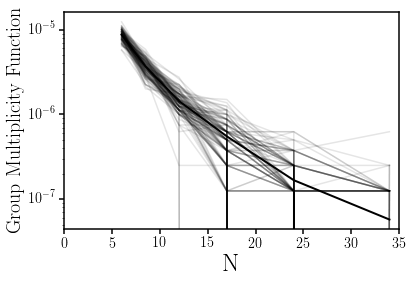

In [17]:
fig = plt.figure()
sub = fig.add_subplot(111)
print np.array(gmfs).shape[0]
for gmf in gmfs: 
    sub.plot(0.5*(gmf_bins[1:] + gmf_bins[:-1]), gmf, c='k', alpha=0.1)
sub.plot(0.5*(gmf_bins[1:] + gmf_bins[:-1]), gmf_avg, c='k', lw=2)
sub.set_xlim([0.,35])
sub.set_xlabel('N', fontsize=25)
sub.set_ylabel('Group Multiplicity Function', fontsize=20)
sub.set_yscale("log")

Now we can use the GMFs to calculate covariance matrix

In [18]:
C_gmf = np.cov(np.array(gmfs).T)
print C_gmf.shape

(6, 6)


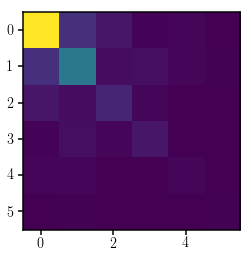

In [96]:
plt.imshow(C_gmf)

Now the question is, how does the pdf of the GMFs diverge from a multivariate Gaussian with covariance $C_\mathrm{gmf}$? One way to quantify this is to calculate the divergence between the GMFs and a multivare Gaussian

In [15]:
mvn = np.random.multivariate_normal

In [112]:
gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=200) # reference Gaussian distribution

(1e-06, 6e-06)

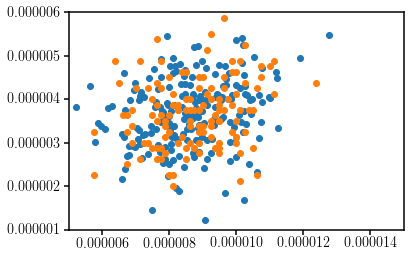

In [115]:
plt.scatter(gauss[:,0]+gmf_avg[0], gauss[:,1]+gmf_avg[1])
plt.scatter(np.array(gmfs)[:,0], np.array(gmfs)[:,1])
plt.xlim([5e-6,1.5e-5])
plt.ylim([1e-6,6e-6])

In [140]:
kNN = KNNDivergenceEstimator(div_funcs=["renyi:.1"], Ks=[3], version='slow')

In [141]:
feat = Features([np.abs(np.array(gmfs)-gmf_avg), gauss])
div_knn = kNN.fit_transform(feat)
print div_knn

[[[[-0.          0.84915936]
   [ 0.         -0.        ]]]]


In [142]:
feat = Features([np.array(gmfs)-gmf_avg, gauss])
div_knn = kNN.fit_transform(feat)
print div_knn

[[[[-0.          0.84915936]
   [ 0.         -0.        ]]]]


In [143]:
gauss_2 = mvn(np.zeros(len(gmf_avg)), C_gmf, size=len(gmfs))

In [144]:
feat = Features([gauss, gauss_2])
print feat

<Features: 2 bags with 124 to 200 6-dimensional points (324 total)>


In [145]:
div_knn = kNN.fit_transform(feat)
print div_knn

[[[[-0.          0.        ]
   [ 0.84915936 -0.        ]]]]
